# **Лабораторна робота №2**
## з дисципліни **"Аналіз часових рядів"**

##### *За темою:* **"Обчислення ковзного середнього та часткової автокореляційної функції"**

<div style="display: flex;">

<div style="flex: 1;">
    <i>Виконавці роботи:</i><br>
    бригада №21
    <br><br>
    <i><b>
    Баштовий Іван<br>
    Гармаш Іван<br>
    Гавлицький Іван<br>
    Харитонов Олександр<br>
    Ходаковський Артур
    </i></b>
</div>

<div style="flex: 1;">
<i>Прийняла:</i>
<br><br><br><br>
<i><b>Левенчук<br> Людмила Борисівна</i></b>
</div>

</div>

##### *Мета роботи:* освоїти методику та зрозуміти сенс обчислення ковзного середнього та часткової автокореляційної функції.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.stattools import pacf

np.random.seed(0)

## Варіант 13


In [2]:
a = np.array([0.1, 0.21, 0.32, 0.43])
b = np.array([1, 0.4, 0.4, 0.2]) # [1, ...] параметр біля v[k]

load_from_file = False
autoregression_rate, moving_average_rate = 3, 3

## **Хід роботи**

### 1. Генерація часового рядку

In [3]:
def get_ts_vectors_from_files(filename1="RTSmm.txt", filename2="2007rts1.txt"):
    v=np.loadtxt(filename1)
    y=np.loadtxt(filename2)
    return v, y


def generate_ts_vectors(a, b, autoregression_rate, moving_average_rate):
    a_ = a[:autoregression_rate+1]
    b_ = b[:moving_average_rate+1]

    v = np.random.normal(loc=0.0, scale=1.0, size=(100,))
    eps = np.random.normal(loc=0.0, scale=1.0, size=(100,))
    y = np.zeros_like(v)

    model_start_index = max(autoregression_rate, moving_average_rate)
    y[:model_start_index] = v[:model_start_index]

    for ii in range(model_start_index, v.shape[0]):
        y_temp = np.flip(y[ii-autoregression_rate:ii])
        v_temp = np.flip(v[ii-moving_average_rate:ii+1])

        y[ii] = a_[0] + a_[1:].dot(y_temp) + b_.dot(v_temp) + eps[ii]

    return v, y

### 2. Зобразимо згенеровані часові ряди

In [4]:
def graph_of_ts(ts_list, labels):
    max_len = len(max(ts_list, key=len))
    indices = list(range(max_len))

    for ii, ts in enumerate(ts_list):
        plt.plot(indices[-len(ts):], ts, label=labels[ii])

    plt.legend()
    plt.show()

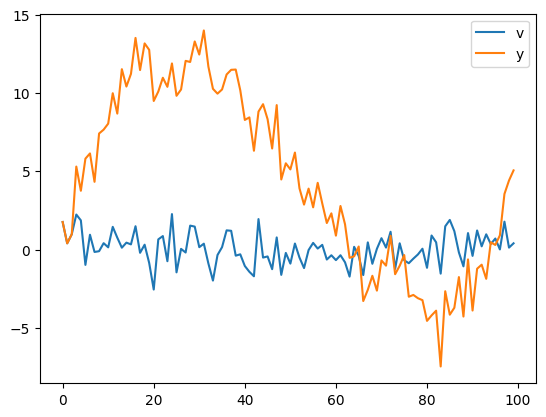

In [5]:
v, y = generate_ts_vectors(a, b, autoregression_rate, moving_average_rate)

graph_of_ts(ts_list=[v, y], labels=['v', 'y'])

### 3. Для завантажених з файлів часових рядів обчислимо ***MA***, ***EMA*** та ***PAF***

#### Вивантаження файлів

In [6]:
ts1, ts2 = get_ts_vectors_from_files(filename1="RTSmm.txt", filename2="2007rts1.txt")

#### Необхідні функції

In [7]:
def moving_average_ts(ts, window_size, exp = False):
    w = np.array([(1-2/(window_size+1))**n if exp else 1 for n in range(1, window_size+1)])
    w = np.flip(w)

    return np.array([(ts[ii-window_size:ii]@w)/w.sum() for ii in range(window_size, ts.size)])

In [8]:
def autocorrelation_function(ts, n_lags):
    ts_pemp = ts - ts.mean()
    var = np.cov(ts)
    n = ts.size

    corr = [1. if l==0 else np.sum(ts_pemp[l:]*ts_pemp[:-l])/(n-1)/var for l in range(n_lags+1)]

    return np.array(corr)


def partial_autocorrelation_function(ts, n_lags):
    r = autocorrelation_function(ts, n_lags)
    F = np.zeros((n_lags+1, n_lags+1))
    
    F[0, 0] = r[0]
    F[1, 1] = r[1]

    for n in range(2, n_lags+1):
        F[n, n] = (r[n] - F[n-1, 1:n] @ np.flip(r[1:n])) / (1 - F[n-1, 1:n] @ r[1:n])
        F[n, 1:n] = F[n-1, 1:n] - F[n, n] * np.flip(F[n-1, 1:n])

    return np.diag(F)

#### Часовий ряд ***RTSmm***

##### Ковзне середнє

In [9]:
window_size = 10

In [10]:
ts1_ma = moving_average_ts(ts=ts1, window_size=window_size, exp=False)
ts1_ema = moving_average_ts(ts=ts1, window_size=window_size, exp=True)

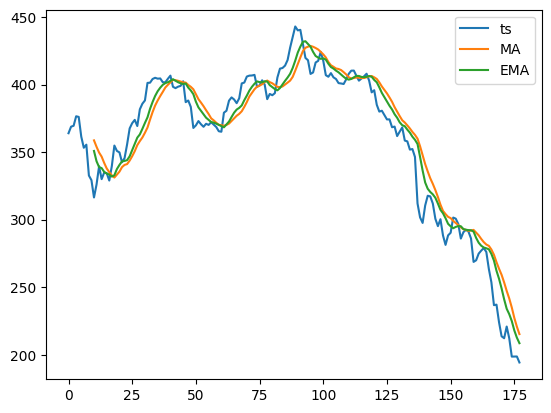

In [11]:
graph_of_ts(ts_list=[ts1, ts1_ma, ts1_ema], labels=['ts', 'MA', 'EMA'])

##### Часткова автокореляційна функція

In [12]:
n_lags = 5

In [13]:
partial_autocorrelation_function(ts=ts1, n_lags=n_lags)

array([ 1.        ,  0.96833997, -0.0553294 , -0.02885423, -0.03046501,
        0.06384663])

Порівняємо з результатом вже існуючої функції

In [14]:
pacf(ts1, n_lags, method='ldb')

array([ 1.        ,  0.96833997, -0.0553294 , -0.02885423, -0.03046501,
        0.06384663])

#### Часовий ряд ***2007rts1***

##### Ковзне середнє

In [15]:
window_size = 5

In [16]:
ts2_ma = moving_average_ts(ts=ts2, window_size=window_size, exp=False)
ts2_ema = moving_average_ts(ts=ts2, window_size=window_size, exp=True)

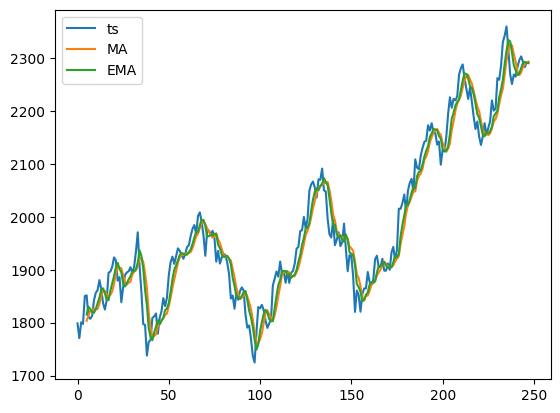

In [17]:
graph_of_ts(ts_list=[ts2, ts2_ma, ts2_ema], labels=['ts', 'MA', 'EMA'])

##### Часткова автокореляційна функція

In [18]:
n_lags = 5

Обчислимо

In [19]:
partial_autocorrelation_function(ts=ts2, n_lags=n_lags)

array([ 1.        ,  0.97486682, -0.04950712,  0.00419376, -0.00625485,
       -0.02939434])

Порівняємо з результатом вже існуючої функції

In [20]:
pacf(ts2, n_lags, method='ldb')

array([ 1.        ,  0.97486682, -0.04950712,  0.00419376, -0.00625485,
       -0.02939434])

## **Висновки**
##### Ми освоїти методику та зрозуміти сенс обчислення ковзного середнього та часткової автокореляційної функції.